In [1]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange

In [2]:
N_skin = 600
N_bandage = 400

In [3]:
# create cubic bezier spline control
u = torch.linspace(0, 1, 3).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[ 0.0098, -0.0098,  0.0035]])
start_point = torch.from_numpy(start_point).to(cfg.device)
## Parallel peeling control
# spline_control = np.array([ [0,  0.0367,  0.57],
#                             [1,  0.0367,  0.67],
#                             [2,  0.0367,  0.77]])
# Straight up peeling control
spline_control = np.array([[ 0.0098, -0.0098,  0.0045],
                           [ 0.0098, -0.0098,  0.0055],
                           [ 0.0098, -0.0098,  0.0065]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [4]:
contact_sur_0 = torch.tensor([ 808,  809,  816,  825,  841,  842,  846,  848,  854,  858,  875,  880,
          882,  885,  904,  916,  917,  919,  926,  927,  928,  929,  930,  931,
          932,  933,  934,  935,  936,  937,  938,  939,  940,  941,  942,  943,
          944,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,  955,
          956,  957,  958,  959,  960,  961,  962,  963,  964,  965,  966,  967,
          968,  969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
          980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,  991,
          992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003,
         1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015,
         1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027,
         1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039,
         1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051,
         1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063,
         1064, 1065, 1066, 1067, 1068]) - 807

contact_sur_1 = torch.tensor([ 43,  50,  51,  54,  60,  61,  92, 103, 104, 106, 108, 110, 117, 154,
         158, 164, 165, 166, 168, 170, 176, 197, 198, 219, 220, 223, 228, 229,
         230, 235, 238, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
         429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
         443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
         457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
         471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
         485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
         499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
         513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526,
         527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540,
         541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554,
         555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568,
         569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
         583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596,
         597, 598, 599])

In [5]:
control_point = 43

In [6]:
# load data
softbody = XPBDSoftbody()
# skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.004), n_surf=N_skin)
skin_mesh = softbody.add_mesh(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.004), n_surf=N_skin)
# bandage_mesh = softbody.add_mesh(pv.Cube(center=(0, 0, 0.003), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.003), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.init_shape_constraints_thinshell([0, 1])
softbody.add_multi_boundary_constrain(1, 0, 0.0017, contact_sur_0, contact_sur_1)
# softbody.set_gravity(torch.tensor([0, 0, -9.8]).to(cfg.device))
softbody.fix_less_than(0, -0.001, 2)
softbody.fix_point(1, control_point)
# softbody.fix_less_than(1, 0.0022, 2)
# softbody.fix_larger_than(0, 0.0018, 2)
p_skin = skin_mesh.points.shape[0]

detect 2 object


In [7]:
softbody.V_list[1][control_point]

tensor([ 0.0098, -0.0097,  0.0035], dtype=torch.float64)

In [8]:
norm_vec = np.array([-1, 1, 0])
center = (0, 0, 0)
sig_plane = pv.Plane(center=center, direction=norm_vec, i_size=0.01, j_size=0.01)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


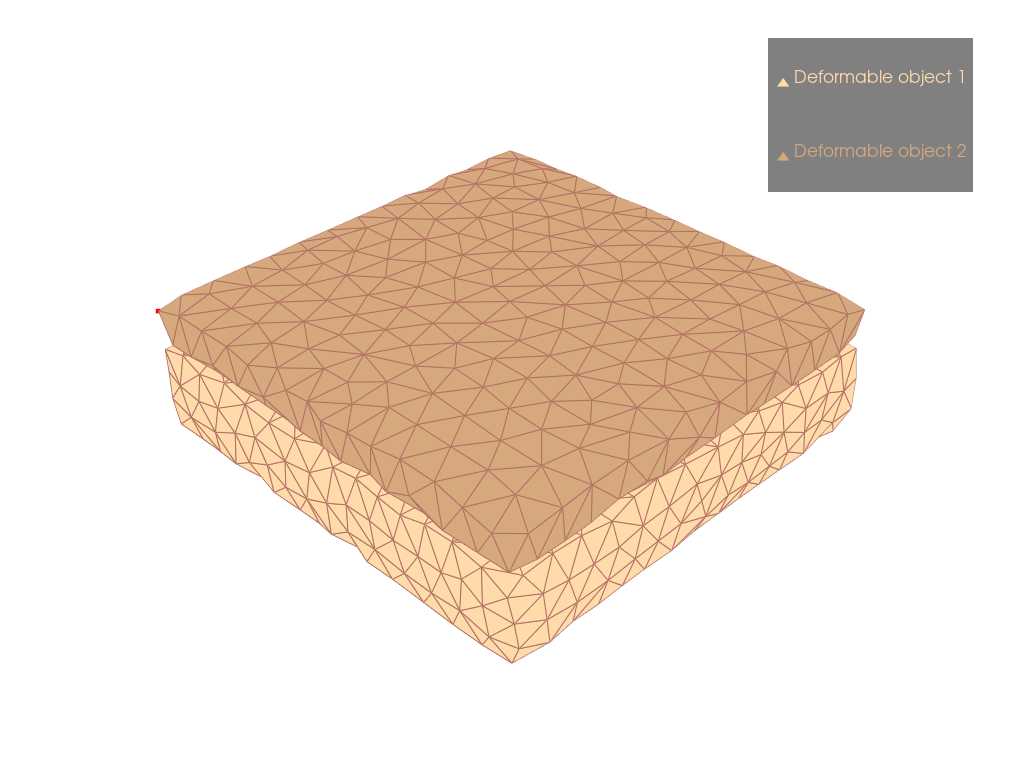

In [9]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_mesh(sig_plane)
pl.add_points(softbody.V[softbody.offset_list[1] + control_point].cpu().numpy(), color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [10]:
softbody.C_boundary_list[0].shape

torch.Size([754, 2])

In [11]:
# color = np.zeros(400)
# color[306] = 1

In [12]:
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_boundary_stiffness = V_boundary_stiffness.type(torch.DoubleTensor)
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
energy_threshold = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device).type(torch.DoubleTensor) * 1e-8
energy_max = 1e-7
energy_min = 1e-8

In [13]:
stiffness_norm = -np.array([-1, -1, 0])
stiffness_color = []
cnt = 0
for i in range(contact_sur_0.shape[0]):
    if (stiffness_norm @ softbody.V_list[1][contact_sur_0[i]].detach().cpu().numpy()) < 0:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max
        stiffness_color.append(energy_max)
        cnt += 1
    else:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
        stiffness_color.append(energy_min)

In [14]:
# contact_sur.shape[0]

In [15]:
# cnt

In [16]:
# center = torch.tensor([0, 0, 0])
# N_norm = torch.norm(softbody.V_list[1][contact_sur] - center, dim=1)
# stiffness_color = []
# for i in range(contact_sur.shape[0]):
#     energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max -  N_norm[i]*(energy_max - energy_min) / (N_norm.max() - N_norm.min()) + energy_max - N_norm.max()*(energy_max - energy_min) / (N_norm.max() - N_norm.min())
#     stiffness_color.append(energy_max - N_norm[i]*(energy_max - energy_min) / (N_norm.max() - N_norm.min()) + energy_max - N_norm.max()*(energy_max - energy_min) / (N_norm.max() - N_norm.min()))

In [17]:
# picked_stiffness = torch.from_numpy(np.array([228, 252, 253, 254, 205, 216, 215, 212, 211, 243, 213, 213, 213, 213, 261, 247, 257, 221, 222, 222, 222, 222, 227, 224, 232, 230]))
# stiffness_color = []
# for i in range(contact_sur.shape[0]):
#     if contact_sur[i] in picked_stiffness:
#         energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max
#         stiffness_color.append(energy_max)
#     else:
#         energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
#         stiffness_color.append(energy_min)

In [18]:
torch.sum(energy_threshold == 1e-7)

tensor(371)

In [19]:
V_boundary_stiffness_origin = V_boundary_stiffness.clone()
energy_coff = 15 / energy_threshold

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


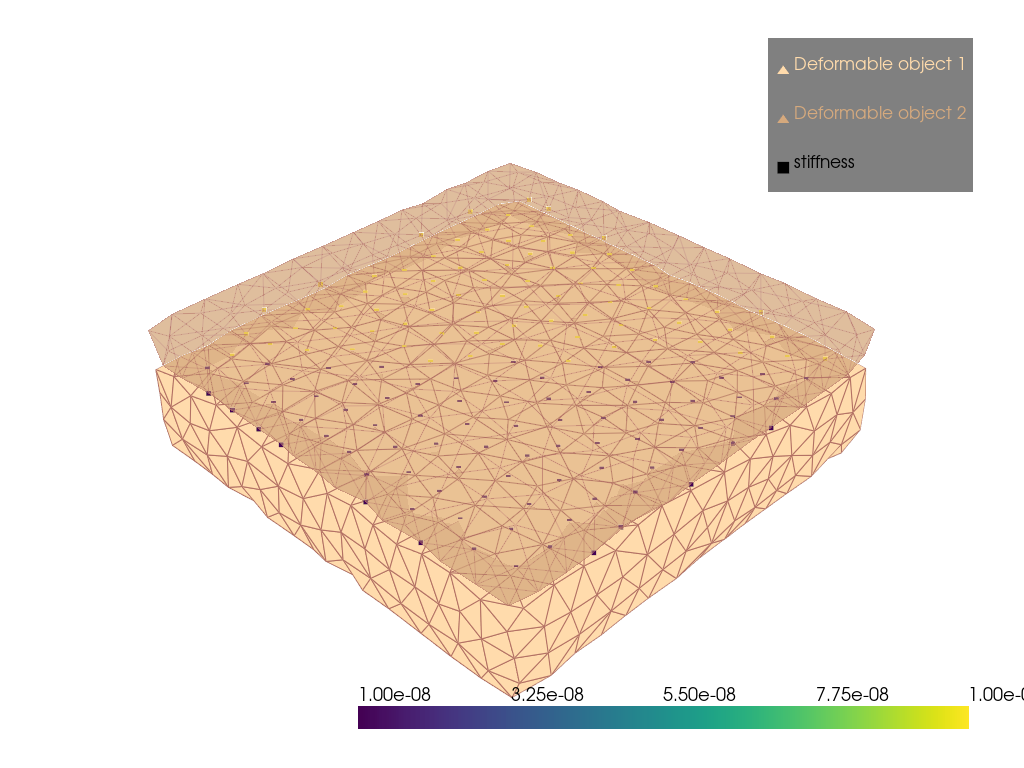

In [20]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V_list[1][contact_sur_0].cpu().numpy(), scalars=stiffness_color, label='stiffness')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [21]:
select_points = []
for i in range(softbody.V_list[1].shape[0]):
    if (norm_vec @ softbody.V_list[1][i].detach().cpu().numpy()) < 0:
        select_points.append(i + softbody.offset_list[1])

In [22]:
reveal_points = []
for i in softbody.C_boundary_V_0[0]:
    if i in select_points:
        reveal_points.append(i)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


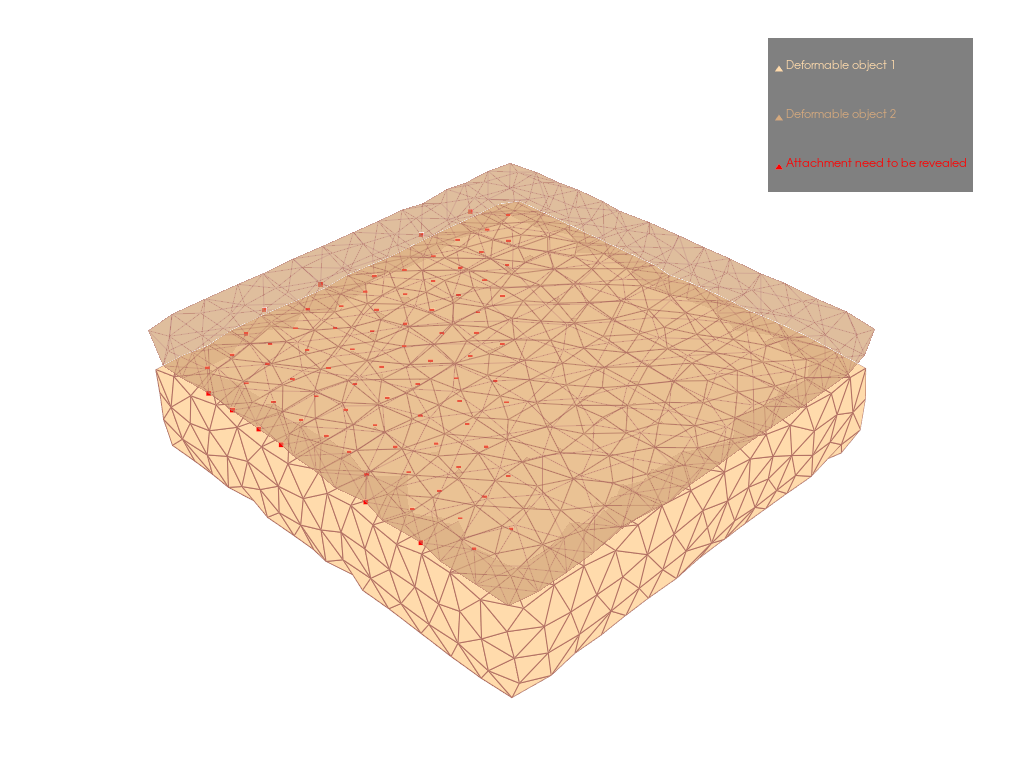

In [23]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V[reveal_points].cpu().numpy(), color='r', label='Attachment need to be revealed')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [24]:
boundary_mask = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * 10
for i in reveal_points:
    idx = torch.where(softbody.C_boundary_V_0[0] == i)[0]
    # print(idx)
    boundary_idx = softbody.C_boundary_lut_0[0][idx]
    boundary_mask[boundary_idx] = 1e-8

In [25]:
def loss_fn(predict, target, penalty, energy, alpha=1e6, beta=1):
    return torch.norm(target - predict) / 100 + penalty * alpha + energy * 1e5

In [26]:
## evaluation function
def eval(predict, target):
    predict_revealed = predict < 1e-2
    predict_unrevealed = predict > 1e-2
    # print(torch.sum(predict_revealed))
    target_revealed = target < 1e-2
    target_unrevealed = target > 1e-2

    # calculate arrcuary reveal
    reveal_acc = torch.sum(torch.logical_and(predict_revealed, target_revealed)) / torch.sum(target_revealed)
    unreveal_acc = torch.sum(torch.logical_and(predict_unrevealed, target_unrevealed)) / torch.sum(target_unrevealed)

    return reveal_acc, unreveal_acc

In [27]:
softbody.V[softbody.offset_list[1] + 306]

tensor([-0.0008, -0.0059,  0.0040])

In [28]:
# torch.autograd.set_detect_anomaly(False)
softbody.C_boundary_list[0].shape

torch.Size([754, 2])

In [29]:
spline_list = []

In [30]:
# init stiffness
cloth_dist_stiffness = 0.1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_boundary_stiffness = V_boundary_stiffness.type(torch.DoubleTensor)

In [31]:

def control_opt(softbody, start_point, control_points, dist_stiff, boundary_stiff, shape_stiff, opt_itr=5, opt_step=5):
    spline_control = control_points.detach().clone()
    spline_control = spline_control.requires_grad_(True)
    # print(spline_control)
    optimizer = torch.optim.Adam([spline_control], lr=0.001)
    V_origin = softbody.V.detach().clone()
    V_velocity_origin = softbody.V_velocity.detach().clone()
    for t in range(opt_itr):
        # get cubic bezier spline control after step
        x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
        y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
        z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
        spline = cubic_bezier_arc_3D(x_con, y_con, z_con, 0.0005)
        spline_x = spline[0]
        spline_y = spline[1]
        spline_z = spline[2]
        spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
        # print(spline_trajectory)
        # restore original vertex and velocity
        softbody.V = V_origin.clone()
        softbody.V_velocity = V_velocity_origin.clone()

        # restore stiffness
        V_dist_stiffness = dist_stiff.clone()
        V_shape_stiffness = shape_stiff.clone()
        V_boundary_stiffness = boundary_stiff.clone()

        energy_total = torch.zeros(1)
        # for i in trange(spline_trajectory.shape[0]):
        for i in range(opt_step):
            softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
            
            step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=V_shape_stiffness,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=True,
                        use_spring_boundary=True,
                        use_dist=True)
            V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
            softbody.V = V_ref.clone()
            softbody.V_velocity = V_velocity_ref.clone()
            # print((softbody.V == torch.inf).any())
            ref_V_boundary_stiffness = V_boundary_stiffness.clone()
            energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
            V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
            energy_total += torch.sum(energy)
            # V_boundary_stiffness = (V_boundary_stiffness * energy_level + V_boundary_stiffness) / 2 + (1e-8 * (-energy_level) + 1e-8) / 2
            # V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(9 * energy_level) + 1e-8 * torch.sigmoid(9 * energy_level)
            skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
            bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()

        # loss = torch.norm(V_boundary_stiffness)
        energy_avg = energy_total / spline_trajectory.shape[0]
        constrain = torch.sigmoid(1e8 * (start_point[:, 2] - spline_trajectory[1:, 2]))
        constrain = torch.sum(constrain)
        TT_score, NN_score = eval(V_boundary_stiffness, boundary_mask)
        loss = loss_fn(V_boundary_stiffness, boundary_mask, constrain, energy_avg, alpha=0, beta=TT_score)
        loss.backward()
        
        # print('loss:', loss)
        # print('Accuracy:', TT_score, NN_score)
        # print('avg energy:', energy_avg)
        # print('constrain', constrain)
        # print(spline_control.grad)
        optimizer.step()
        optimizer.zero_grad()
    # pl = pv.Plotter()
    # pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
    # pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
    # pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
    # # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
    # pl.add_legend()
    # pl.camera_position = 'iso'
    # pl.show()
    return spline_trajectory[1], energy_avg, TT_score, NN_score, constrain

In [32]:
# init a trajectory for control
x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
spline = cubic_bezier_arc_3D(x_con, y_con, z_con, 0.0005)
spline_x = spline[0]
spline_y = spline[1]
spline_z = spline[2]
spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)

In [33]:
for i in trange(spline_trajectory.shape[0]):
    # for i in range(1):
    softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
    
    step_ref = XPBDStep(softbody,
                V_dist_stiffness=V_dist_stiffness, 
                V_shape_stiffness=V_shape_stiffness,
                V_boundary_stiffness=V_boundary_stiffness, 
                dt=cfg.dt,
                substep=cfg.substep,
                iteration=cfg.iteration,
                quasi_static=cfg.quasi_static,
                plane_height=cfg.ground_plane_height, 
                use_shape_matching=True,
                use_spring_boundary=True,
                use_dist=True)
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    # print((softbody.V == torch.inf).any())
    ref_V_boundary_stiffness = V_boundary_stiffness.clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))

100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


In [34]:
spline_trajectory

tensor([[ 0.0098, -0.0098,  0.0035],
        [ 0.0098, -0.0098,  0.0040],
        [ 0.0098, -0.0098,  0.0045],
        [ 0.0098, -0.0098,  0.0050],
        [ 0.0098, -0.0098,  0.0055],
        [ 0.0098, -0.0098,  0.0060]], dtype=torch.float64)

In [35]:
sigma = 0.005
sample_points = 5

In [36]:
V_origin = softbody.V.clone()
V_velocity_origin = softbody.V_velocity.clone()

In [37]:
# control_opt(softbody, start_point, spline_control, V_dist_stiffness, V_boundary_stiffness, V_shape_stiffness)

In [38]:
for t in range(30):
    # sampling
    direct_vect = spline_trajectory[-1] - spline_trajectory[-2]
    start_point = spline_trajectory[-1]
    end_point = start_point + 10 * direct_vect
    sample_x = torch.empty(sample_points).normal_(mean=float(end_point[0]),std=sigma)
    sample_y = torch.empty(sample_points).normal_(mean=float(end_point[1]),std=sigma)
    sample_z = torch.empty(sample_points).normal_(mean=float(end_point[2]),std=sigma)

    end_points = torch.vstack((sample_x, sample_y, sample_z))
    end_points = torch.transpose(end_points, 0, 1)

    spline_control = torch.zeros((sample_points, 3))
    energy_avg = torch.zeros(sample_points)
    TT_score = torch.zeros(sample_points)
    NN_score = torch.zeros(sample_points)
    constrain_score = torch.zeros(sample_points)

    start_point = start_point.reshape(1, 3)

    # sampling trajectory opt
    for i in trange(sample_points):
        softbody.V = V_origin.clone()
        softbody.V_velocity = V_velocity_origin.clone()
        direction = end_points[i] - torch.mean(spline_trajectory, dim=0)
        direction = direction / (torch.norm(direction) / 0.0005) * 10
        spline_ctrl = torch.zeros((3, 3))
        spline_ctrl[0] = start_point + direction / 3
        spline_ctrl[1] = start_point + direction * 2 / 3
        spline_ctrl[2] = end_points[i]
        
        start_point = start_point.detach()
        V_dist_stiffness = V_dist_stiffness.detach()
        V_boundary_stiffness = V_boundary_stiffness.detach()
        V_shape_stiffness = V_shape_stiffness.detach()
        
        spline_control[i], energy_avg[i], TT_score[i], NN_score[i], constrain_score[i] = control_opt(softbody, start_point, spline_ctrl, V_dist_stiffness, V_boundary_stiffness, V_shape_stiffness)
        print(spline_control[i], energy_avg[i], TT_score[i], NN_score[i], constrain_score[i])

    # choose the best step
    next_idx = torch.where(energy_avg == energy_avg.min())
    spline_trajectory = torch.vstack((spline_trajectory, spline_control[next_idx]))
    softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[-1]
    step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=V_shape_stiffness,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=True,
                        use_spring_boundary=True,
                        use_dist=True)
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    # print((softbody.V == torch.inf).any())
    ref_V_boundary_stiffness = V_boundary_stiffness.clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
    skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
    bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()
    
    pl = pv.Plotter()
    pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
    pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
    pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
    # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
    pl.add_legend()
    pl.camera_position = [(0.04943279151406822, -0.03977536222547223, 0.021820325700180415),
                          (7.301401243626354e-06, 2.0879731106636726e-05, 0.003000000142492353),
                          (-0.23015530645193596, 0.1675075959527941, 0.95862909418092)]
    pl.show()

 20%|██        | 1/5 [00:08<00:34,  8.74s/it]

tensor([ 0.0095, -0.0095,  0.0058], grad_fn=<SelectBackward0>) tensor(5.6056e-08, grad_fn=<SelectBackward0>) tensor(0.0212) tensor(1.) tensor(13., grad_fn=<SelectBackward0>)


 40%|████      | 2/5 [00:16<00:24,  8.13s/it]

tensor([ 0.0095, -0.0095,  0.0062], grad_fn=<SelectBackward0>) tensor(1.7713e-07, grad_fn=<SelectBackward0>) tensor(0.0212) tensor(1.) tensor(2., grad_fn=<SelectBackward0>)


 60%|██████    | 3/5 [00:24<00:16,  8.25s/it]

tensor([ 0.0095, -0.0101,  0.0062], grad_fn=<SelectBackward0>) tensor(2.1588e-07, grad_fn=<SelectBackward0>) tensor(0.0317) tensor(1.) tensor(0., grad_fn=<SelectBackward0>)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ffb38cd0df0>>
Traceback (most recent call last):
  File "/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 80%|████████  | 4/5 [00:33<00:08,  8.26s/it]

tensor([ 0.0096, -0.0097,  0.0056], grad_fn=<SelectBackward0>) tensor(7.5818e-08, grad_fn=<SelectBackward0>) tensor(0.0212) tensor(1.) tensor(14., grad_fn=<SelectBackward0>)


100%|██████████| 5/5 [00:41<00:00,  8.33s/it]

In [ ]:
TT_score

tensor([0.5474, 0.5474, 0.5474, 0.5474, 0.5474])

In [ ]:
NN_score

tensor([0.8993, 0.8993, 0.8993, 0.8993, 0.8993])

In [ ]:
energy_avg

tensor([3.7979e-07, 2.9893e-07, 3.2937e-07, 2.9444e-07, 3.6358e-07],
       grad_fn=<CopySlices>)

In [ ]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'

In [ ]:
pl.open_gif('MPC_test2.gif')
softbody.V = V_origin.clone()
softbody.V_velocity = V_velocity_origin.clone()

# restore stiffness
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 10
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.001
V_shape_stiffness[:600] = 0.001
V_shape_stiffness[600:] = 0.000001
V_dist_stiffness[:600] = 1
V_dist_stiffness[600:] = 0.1
spline_actor = pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')

for i in trange(spline_trajectory.shape[0]):
    softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
    
    step_ref = XPBDStep(softbody,
                V_dist_stiffness=V_dist_stiffness, 
                V_shape_stiffness=V_shape_stiffness,
                V_boundary_stiffness=V_boundary_stiffness, 
                dt=cfg.dt,
                substep=cfg.substep,
                iteration=cfg.iteration,
                quasi_static=cfg.quasi_static,
                plane_height=cfg.ground_plane_height, 
                use_shape_matching=True,
                use_spring_boundary=True,
                use_dist=True)
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    # print((softbody.V == torch.inf).any())
    ref_V_boundary_stiffness = V_boundary_stiffness.clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
    skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
    bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()
    # print(V_boundary_stiffness)
    pl.write_frame()
# pl.add_text('Accuracy: (tensor(0.8880), tensor(0.9057))')
# loss = torch.norm(V_boundary_stiffness)

pl.close()

100%|██████████| 36/36 [00:07<00:00,  4.68it/s]
